NCAA bracket predictions 2017
---

Import necessary dependencies

In [41]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import isnan

Create some helper functions

In [42]:
def from_csv(path):
    csv = pd.read_csv(path)
    return np.asarray(csv)

Run a logistic regression against the pointspread data

In [43]:
# year, spread, home_id, home_team, home_offense, home_defense, away_id, away_team, away_offense, away_defense, winloss
data = from_csv('./datasets/full_spreads.csv')

spreads = data[:, 1].reshape(-1, 1)
labels = np.asarray(data[:, -1], dtype='int')

spread_classifier = LogisticRegression(solver='lbfgs')
spread_classifier.fit(spreads, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

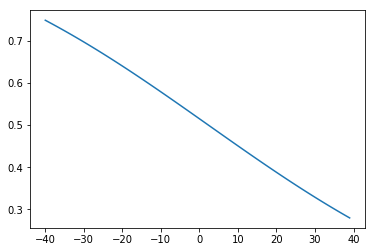

In [44]:
range_of_spreads = np.arange(-40, 40)
range_of_spreads.shape = (80,1)

predictions = spread_classifier.predict_proba(range_of_spreads)[:, 1]

plt.plot(range_of_spreads, predictions)
plt.show()

After the first round, no pointspread data will be available, so we'll need to estimate the pointspread based on the team stats.  Run a linear regression on historical matchup data

In [45]:
# year, spread, home_id, home_team, home_offense, home_defense, away_id, away_team, away_offense, away_defense, winloss
pointspreads = []
historical_stats = []

for index in range(0, len(data)):
    row = data[index]
    if not isnan(row[4]) and not isnan(row[5]) and not isnan(row[8]) and not isnan(row[9]):
        historical_stats.append([row[4], row[5], row[8], row[9]])
        pointspreads.append(row[1])

regressor = LinearRegression()
regressor.fit(historical_stats, pointspreads)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Run a logistic regression against the team stats for each game

In [46]:
# year, home_id, home_team, home_offense, home_defense, away_id, away_team, away_offense, away_defense, 
# neutral_site, home_win
game_data = from_csv('./datasets/games_since_2002.csv')

stats = [[row[3], row[4], row[7], row[8], row[9]] for row in game_data]
labels = np.asarray(game_data[:, -1], dtype='int')

game_classifier = LogisticRegression(solver = 'lbfgs')
game_classifier.fit(stats, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

Predict the winner based on the game data

In [47]:
# home_offense,home_defense,away_offense,away_defense,neutral_location,home_team,away_team
all_matchups = from_csv('./datasets/bracket.csv')

games = all_matchups[:, :-2]
games_without_location = games[:, :-1]
estimated_spreads = regressor.predict(games_without_location).reshape(-1, 1)
teams = all_matchups[:, -2:]

outcomes_from_spreads = spread_classifier.predict_proba(estimated_spreads)[:, 1]
outcomes_from_games = game_classifier.predict_proba(games)[:, 1]
predictions = (0.25 * outcomes_from_spreads) + (0.75 * outcomes_from_games)

for index in range(0, 10):
    print "{} over {} probability is {:.2f}%".format(teams[index][0], teams[index][1], predictions[index] * 100)

print "..."

Gonzaga over Villanova probability is 61.13%
Gonzaga over North Carolina probability is 67.31%
Gonzaga over Kentucky probability is 68.71%
Gonzaga over West Virginia probability is 69.67%
Gonzaga over Louisville probability is 69.88%
Gonzaga over Virginia probability is 69.80%
Gonzaga over Wichita St probability is 70.53%
Gonzaga over Florida probability is 70.44%
Gonzaga over Kansas probability is 71.51%
Gonzaga over SMU probability is 72.60%
...


Allow manual entry to inspect outcomes

In [48]:
manual = {}

for index in range(0, len(teams)):
    home = teams[index][0]
    away = teams[index][1]
    
    value = manual.get(home, {})
    value[away] = predictions[index]
    manual[home] = value
    
for index in range(0, len(teams)):
    home = teams[index][0]
    away = teams[index][1]
    
    value = manual.get(away, {})
    value[home] = 1 - predictions[index]
    manual[away] = value

Manually retrieve results

In [49]:
manual_home_team = "Marquette"
manual_away_team = "South Carolina"
percent = manual[manual_home_team][manual_away_team] * 100

print "{} over {} is {:.2f}%".format(manual_home_team, manual_away_team, percent)

Marquette over South Carolina is 54.85%


Save the predictions to a CSV for uploading to Kaggle

In [39]:
ids = pd.read_csv('./datasets/ids.csv')

def name_to_id(name, ids):
    return np.asarray(ids.loc[ids['Team_Name'] == name]['Team_Id'])[0]

results = []

for index in range(0, len(predictions)):
    home_name = teams[index][0]
    away_name = teams[index][1]
    home_id = name_to_id(home_name, ids)
    away_id = name_to_id(away_name, ids)
    
    if int(home_id) < int(away_id):
        results.append(["2017_{}_{}".format(home_id, away_id), predictions[index]])
    
    if int(away_id) < int(home_id):
        results.append(["2017_{}_{}".format(away_id, home_id), 1 - predictions[index]])

pd.DataFrame(data=results).to_csv('./datasets/kaggle_predictions.csv', index=False)